<a href="https://colab.research.google.com/github/grumpybavarian/tensorflow2.0/blob/master/real_nvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
tf.__version__

'2.0.0'

In [0]:
def create_mlp(units, dim, n_layers):
    network = []

    for _ in range(n_layers - 1):
        network += [keras.layers.Dense(units, activation='relu')]

    network += [keras.layers.Dense(dim)]

    return keras.Sequential(network)

In [0]:
class RealNVP(keras.layers.Layer):
  def __init__(self, dim: int, flip: bool, units=128, layers=2):
    super().__init__()
    self.dim = dim
    self.flip = flip
    self.s_net = create_mlp(units, dim, layers)
    self.t_net = create_mlp(units, dim, layers)
    
    # create checkerboard mask
    mask = np.zeros(self.dim)
    start = 0 if self.flip else 1
    mask[np.arange(start, self.dim, 2)] = 1
    self.mask = tf.convert_to_tensor(mask, dtype=tf.float32)

  def call(self, x, sldj=0, reverse=False):
    x1 = self.mask * x
    x2 = (1. - self.mask) * x

    scale = (1 - self.mask) * self.s_net(x1)
    shift = (1 - self.mask) * self.t_net(x1)

    if reverse:
        return x1 + x2 * tf.exp(scale) + shift
    else:
        sldj += tf.reduce_sum(scale, axis=1)

        return x1 + (x2 - shift) * tf.exp(-scale), sldj

In [0]:
class NormalisingFlow(keras.layers.Layer):
  def __init__(self, dim: int, depth: int, units: int = 128, n_layers: int = 2):
    super().__init__()
    self.dim = dim
    self.depth = depth
    self.layers = [RealNVP(dim=dim, flip=(i%2==0), units=units, layers=n_layers)
                   for i in range(depth)]
    
  def call(self, x, reverse=False):
    if reverse:
      for l in reversed(self.layers):
        x = l(x, reverse=True)
      return x
    else:
      sldj = 0.
      for l in self.layers:
        x, sldj = l(x, sldj, reverse=False)

      return x, self.base_log_prob(x) - sldj

  def base_log_prob(self, x):
    return tf.reduce_sum(-tf.square(x) / 2 - tf.math.log(tf.sqrt(2 * np.pi)), axis=1)
      
  def sample(self, n_samples):
    base_samples = tf.random.normal(shape=(n_samples, self.dim))

    return self(base_samples, reverse=True)

In [0]:
# # Test Real NVP layer invertibility
r = RealNVP(10, True)
x = tf.random.normal(shape=(20, 10))
z, _ = r(x, reverse=False)
x_new = r(z, reverse=True)
assert tf.norm(x - x_new) < 1e-5

In [0]:
# # Test Normalising Flow invertibility
flow = NormalisingFlow(dim=10, depth=4)
x = tf.random.normal(shape=(20, 10))
z, _ = flow(x, reverse=False)
x_new = flow(z, reverse=True)
assert tf.norm(x - x_new) < 1e-5

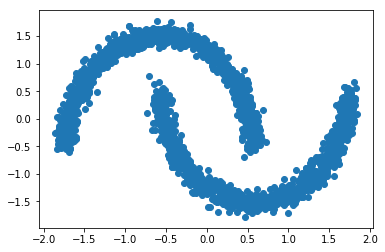

In [9]:
# create dataset
batch_size = 256
X, _ = make_moons(n_samples=2000, noise=0.05)
X = StandardScaler().fit_transform(X).astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.2, )
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(len(X)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)

plt.scatter(X[:, 0], X[:, 1])

In [0]:
optimiser = keras.optimizers.Adam(1e-3)
flow = NormalisingFlow(2, depth=6, units=512, n_layers=3)

In [0]:
def train_one_batch(batch):
  with tf.GradientTape() as tape:
    _, sldj = flow(batch)
    nlls = - sldj
    loss = - tf.reduce_mean(sldj)

    # due to the boolean masking of the output of the s and t net
    # some weights won't have gradients, `unconnected_gradients='zero'` sets
    # these to zero instead of None
    grads = tape.gradient(loss, flow.trainable_variables, unconnected_gradients='zero')

    return nlls, grads
  

def train_one_epoch():
    train_loss_avg = tf.keras.metrics.Mean()
    test_loss_avg = tf.keras.metrics.Mean()

    for batch in train_dataset:
      nlls, grads = train_one_batch(batch)
      optimiser.apply_gradients(zip(grads, flow.trainable_variables))
      train_loss_avg(nlls)

    for batch in test_dataset:
      _, sldj = flow(batch)
      test_loss_avg(-sldj)

    return train_loss_avg.result(), test_loss_avg.result()  

In [0]:
def plot_progress(samples):
  plt.subplot(121)
  plt.title('Dataset')
  plt.scatter(X[:, 0], X[:, 1])
  plt.subplot(122)
  plt.title('Generated Samples')
  plt.scatter(samples[:, 0], samples[:, 1])
  plt.show()

Epoch 0 / 300: Train Loss: 4.501 Test Loss: 3.316


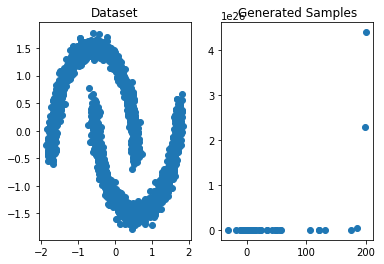

Epoch 1 / 300: Train Loss: 3.360 Test Loss: 3.336
Epoch 2 / 300: Train Loss: 3.282 Test Loss: 3.110
Epoch 3 / 300: Train Loss: 3.307 Test Loss: 3.329
Epoch 4 / 300: Train Loss: 3.210 Test Loss: 3.044
Epoch 5 / 300: Train Loss: 2.916 Test Loss: 2.757
Epoch 6 / 300: Train Loss: 2.649 Test Loss: 2.475
Epoch 7 / 300: Train Loss: 2.470 Test Loss: 2.478
Epoch 8 / 300: Train Loss: 2.430 Test Loss: 2.498
Epoch 9 / 300: Train Loss: 2.521 Test Loss: 2.596
Epoch 10 / 300: Train Loss: 2.489 Test Loss: 2.429
Epoch 11 / 300: Train Loss: 2.412 Test Loss: 2.336
Epoch 12 / 300: Train Loss: 2.310 Test Loss: 2.215
Epoch 13 / 300: Train Loss: 2.234 Test Loss: 2.205
Epoch 14 / 300: Train Loss: 2.344 Test Loss: 2.329
Epoch 15 / 300: Train Loss: 2.520 Test Loss: 2.431
Epoch 16 / 300: Train Loss: 2.540 Test Loss: 2.674
Epoch 17 / 300: Train Loss: 2.660 Test Loss: 2.554
Epoch 18 / 300: Train Loss: 2.411 Test Loss: 2.425
Epoch 19 / 300: Train Loss: 2.347 Test Loss: 2.626
Epoch 20 / 300: Train Loss: 2.787 Test L

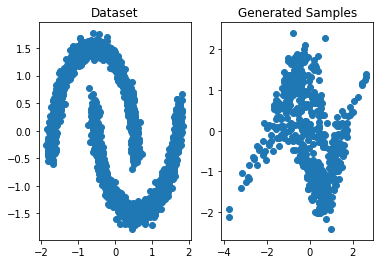

Epoch 26 / 300: Train Loss: 2.254 Test Loss: 2.204
Epoch 27 / 300: Train Loss: 2.173 Test Loss: 2.121
Epoch 28 / 300: Train Loss: 2.105 Test Loss: 2.058
Epoch 29 / 300: Train Loss: 2.041 Test Loss: 2.013
Epoch 30 / 300: Train Loss: 1.997 Test Loss: 1.961
Epoch 31 / 300: Train Loss: 1.999 Test Loss: 2.038
Epoch 32 / 300: Train Loss: 2.272 Test Loss: 2.557
Epoch 33 / 300: Train Loss: 2.793 Test Loss: 2.913
Epoch 34 / 300: Train Loss: 2.864 Test Loss: 2.705
Epoch 35 / 300: Train Loss: 2.634 Test Loss: 2.574
Epoch 36 / 300: Train Loss: 2.449 Test Loss: 2.259
Epoch 37 / 300: Train Loss: 2.723 Test Loss: 3.221
Epoch 38 / 300: Train Loss: 3.304 Test Loss: 3.407
Epoch 39 / 300: Train Loss: 3.223 Test Loss: 3.159
Epoch 40 / 300: Train Loss: 2.950 Test Loss: 2.810
Epoch 41 / 300: Train Loss: 2.656 Test Loss: 2.564
Epoch 42 / 300: Train Loss: 2.424 Test Loss: 2.279
Epoch 43 / 300: Train Loss: 2.289 Test Loss: 2.199
Epoch 44 / 300: Train Loss: 2.134 Test Loss: 2.129
Epoch 45 / 300: Train Loss: 2.0

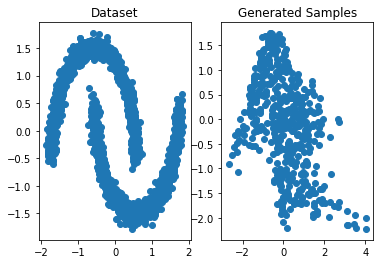

Epoch 51 / 300: Train Loss: 2.213 Test Loss: 2.120
Epoch 52 / 300: Train Loss: 2.125 Test Loss: 2.075
Epoch 53 / 300: Train Loss: 2.057 Test Loss: 1.976
Epoch 54 / 300: Train Loss: 1.993 Test Loss: 1.914
Epoch 55 / 300: Train Loss: 1.920 Test Loss: 1.906
Epoch 56 / 300: Train Loss: 1.877 Test Loss: 1.807
Epoch 57 / 300: Train Loss: 1.842 Test Loss: 1.789
Epoch 58 / 300: Train Loss: 1.811 Test Loss: 1.914
Epoch 59 / 300: Train Loss: 1.834 Test Loss: 1.755
Epoch 60 / 300: Train Loss: 1.745 Test Loss: 1.725
Epoch 61 / 300: Train Loss: 1.754 Test Loss: 1.687
Epoch 62 / 300: Train Loss: 1.719 Test Loss: 1.951
Epoch 63 / 300: Train Loss: 1.897 Test Loss: 1.808
Epoch 64 / 300: Train Loss: 1.851 Test Loss: 1.770
Epoch 65 / 300: Train Loss: 1.861 Test Loss: 1.984
Epoch 66 / 300: Train Loss: 1.955 Test Loss: 1.829
Epoch 67 / 300: Train Loss: 1.822 Test Loss: 1.823
Epoch 68 / 300: Train Loss: 1.754 Test Loss: 1.703
Epoch 69 / 300: Train Loss: 1.698 Test Loss: 1.744
Epoch 70 / 300: Train Loss: 1.6

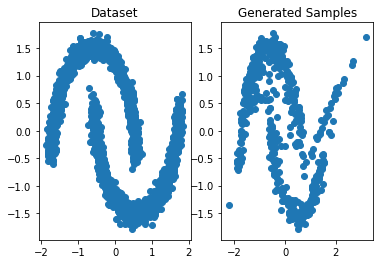

Epoch 76 / 300: Train Loss: 1.506 Test Loss: 1.634
Epoch 77 / 300: Train Loss: 1.526 Test Loss: 1.563
Epoch 78 / 300: Train Loss: 1.521 Test Loss: 1.518
Epoch 79 / 300: Train Loss: 1.505 Test Loss: 1.519
Epoch 80 / 300: Train Loss: 1.516 Test Loss: 1.672
Epoch 81 / 300: Train Loss: 1.710 Test Loss: 1.776
Epoch 82 / 300: Train Loss: 1.760 Test Loss: 1.667
Epoch 83 / 300: Train Loss: 1.616 Test Loss: 1.613
Epoch 84 / 300: Train Loss: 1.539 Test Loss: 1.468
Epoch 85 / 300: Train Loss: 1.490 Test Loss: 1.469
Epoch 86 / 300: Train Loss: 1.486 Test Loss: 1.524
Epoch 87 / 300: Train Loss: 1.503 Test Loss: 1.521
Epoch 88 / 300: Train Loss: 1.523 Test Loss: 1.534
Epoch 89 / 300: Train Loss: 1.471 Test Loss: 1.453
Epoch 90 / 300: Train Loss: 1.453 Test Loss: 1.454
Epoch 91 / 300: Train Loss: 1.486 Test Loss: 1.529
Epoch 92 / 300: Train Loss: 1.509 Test Loss: 1.554
Epoch 93 / 300: Train Loss: 1.498 Test Loss: 1.522
Epoch 94 / 300: Train Loss: 1.507 Test Loss: 1.491
Epoch 95 / 300: Train Loss: 1.5

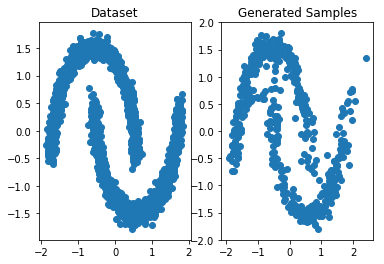

Epoch 101 / 300: Train Loss: 1.455 Test Loss: 1.509
Epoch 102 / 300: Train Loss: 1.484 Test Loss: 1.475
Epoch 103 / 300: Train Loss: 1.457 Test Loss: 1.439
Epoch 104 / 300: Train Loss: 1.428 Test Loss: 1.484
Epoch 105 / 300: Train Loss: 1.405 Test Loss: 1.461
Epoch 106 / 300: Train Loss: 1.461 Test Loss: 1.473
Epoch 107 / 300: Train Loss: 1.484 Test Loss: 1.493
Epoch 108 / 300: Train Loss: 1.493 Test Loss: 1.415
Epoch 109 / 300: Train Loss: 1.422 Test Loss: 1.520
Epoch 110 / 300: Train Loss: 1.469 Test Loss: 1.381
Epoch 111 / 300: Train Loss: 1.393 Test Loss: 1.513
Epoch 112 / 300: Train Loss: 1.546 Test Loss: 1.460
Epoch 113 / 300: Train Loss: 1.457 Test Loss: 1.472
Epoch 114 / 300: Train Loss: 1.465 Test Loss: 1.492
Epoch 115 / 300: Train Loss: 1.412 Test Loss: 1.376
Epoch 116 / 300: Train Loss: 1.387 Test Loss: 1.364
Epoch 117 / 300: Train Loss: 1.381 Test Loss: 1.374
Epoch 118 / 300: Train Loss: 1.399 Test Loss: 1.564
Epoch 119 / 300: Train Loss: 1.485 Test Loss: 1.424
Epoch 120 / 

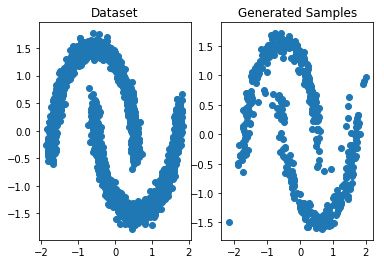

Epoch 126 / 300: Train Loss: 1.303 Test Loss: 1.353
Epoch 127 / 300: Train Loss: 1.311 Test Loss: 1.314
Epoch 128 / 300: Train Loss: 1.329 Test Loss: 1.409
Epoch 129 / 300: Train Loss: 1.335 Test Loss: 1.406
Epoch 130 / 300: Train Loss: 1.371 Test Loss: 1.341
Epoch 131 / 300: Train Loss: 1.355 Test Loss: 1.428
Epoch 132 / 300: Train Loss: 1.358 Test Loss: 1.432
Epoch 133 / 300: Train Loss: 1.417 Test Loss: 1.501
Epoch 134 / 300: Train Loss: 1.414 Test Loss: 1.377
Epoch 135 / 300: Train Loss: 1.393 Test Loss: 1.382
Epoch 136 / 300: Train Loss: 1.337 Test Loss: 1.308
Epoch 137 / 300: Train Loss: 1.278 Test Loss: 1.293
Epoch 138 / 300: Train Loss: 1.295 Test Loss: 1.283
Epoch 139 / 300: Train Loss: 1.310 Test Loss: 1.366
Epoch 140 / 300: Train Loss: 1.305 Test Loss: 1.275
Epoch 141 / 300: Train Loss: 1.246 Test Loss: 1.294
Epoch 142 / 300: Train Loss: 1.278 Test Loss: 1.313
Epoch 143 / 300: Train Loss: 1.288 Test Loss: 1.259
Epoch 144 / 300: Train Loss: 1.283 Test Loss: 1.340
Epoch 145 / 

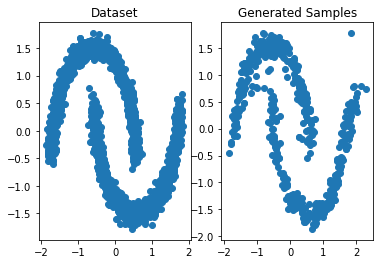

Epoch 151 / 300: Train Loss: 1.340 Test Loss: 1.303
Epoch 152 / 300: Train Loss: 1.292 Test Loss: 1.296
Epoch 153 / 300: Train Loss: 1.302 Test Loss: 1.300
Epoch 154 / 300: Train Loss: 1.276 Test Loss: 1.237
Epoch 155 / 300: Train Loss: 1.268 Test Loss: 1.245
Epoch 156 / 300: Train Loss: 1.260 Test Loss: 1.258
Epoch 157 / 300: Train Loss: 1.314 Test Loss: 1.303
Epoch 158 / 300: Train Loss: 1.342 Test Loss: 1.374
Epoch 159 / 300: Train Loss: 1.353 Test Loss: 1.283
Epoch 160 / 300: Train Loss: 1.252 Test Loss: 1.462
Epoch 161 / 300: Train Loss: 1.273 Test Loss: 1.238
Epoch 162 / 300: Train Loss: 1.269 Test Loss: 1.452
Epoch 163 / 300: Train Loss: 1.360 Test Loss: 1.425
Epoch 164 / 300: Train Loss: 1.324 Test Loss: 1.256
Epoch 165 / 300: Train Loss: 1.255 Test Loss: 1.315
Epoch 166 / 300: Train Loss: 1.262 Test Loss: 1.262
Epoch 167 / 300: Train Loss: 1.257 Test Loss: 1.245
Epoch 168 / 300: Train Loss: 1.250 Test Loss: 1.230
Epoch 169 / 300: Train Loss: 1.232 Test Loss: 1.320
Epoch 170 / 

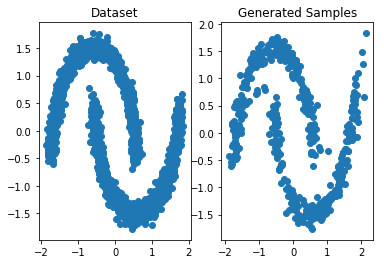

Epoch 176 / 300: Train Loss: 1.319 Test Loss: 1.286
Epoch 177 / 300: Train Loss: 1.337 Test Loss: 1.305
Epoch 178 / 300: Train Loss: 1.301 Test Loss: 1.320
Epoch 179 / 300: Train Loss: 1.260 Test Loss: 1.267
Epoch 180 / 300: Train Loss: 1.277 Test Loss: 1.314
Epoch 181 / 300: Train Loss: 1.359 Test Loss: 1.376
Epoch 182 / 300: Train Loss: 1.354 Test Loss: 1.391
Epoch 183 / 300: Train Loss: 1.307 Test Loss: 1.246
Epoch 184 / 300: Train Loss: 1.242 Test Loss: 1.226
Epoch 185 / 300: Train Loss: 1.217 Test Loss: 1.246
Epoch 186 / 300: Train Loss: 1.238 Test Loss: 1.229
Epoch 187 / 300: Train Loss: 1.219 Test Loss: 1.198
Epoch 188 / 300: Train Loss: 1.208 Test Loss: 1.268
Epoch 189 / 300: Train Loss: 1.245 Test Loss: 1.242
Epoch 190 / 300: Train Loss: 1.214 Test Loss: 1.222
Epoch 191 / 300: Train Loss: 1.245 Test Loss: 1.288
Epoch 192 / 300: Train Loss: 1.224 Test Loss: 1.280
Epoch 193 / 300: Train Loss: 1.219 Test Loss: 1.237
Epoch 194 / 300: Train Loss: 1.232 Test Loss: 1.235
Epoch 195 / 

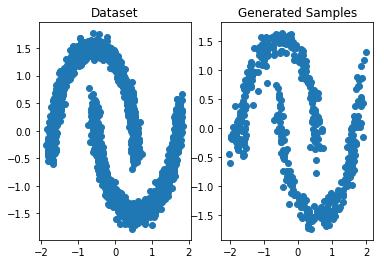

Epoch 201 / 300: Train Loss: 1.274 Test Loss: 1.253
Epoch 202 / 300: Train Loss: 1.298 Test Loss: 1.387
Epoch 203 / 300: Train Loss: 1.300 Test Loss: 1.262
Epoch 204 / 300: Train Loss: 1.231 Test Loss: 1.263
Epoch 205 / 300: Train Loss: 1.209 Test Loss: 1.204
Epoch 206 / 300: Train Loss: 1.198 Test Loss: 1.358
Epoch 207 / 300: Train Loss: 1.237 Test Loss: 1.187
Epoch 208 / 300: Train Loss: 1.223 Test Loss: 1.242
Epoch 209 / 300: Train Loss: 1.266 Test Loss: 1.282
Epoch 210 / 300: Train Loss: 1.241 Test Loss: 1.219
Epoch 211 / 300: Train Loss: 1.224 Test Loss: 1.251
Epoch 212 / 300: Train Loss: 1.218 Test Loss: 1.329
Epoch 213 / 300: Train Loss: 1.274 Test Loss: 1.325
Epoch 214 / 300: Train Loss: 1.257 Test Loss: 1.294
Epoch 215 / 300: Train Loss: 1.299 Test Loss: 1.294
Epoch 216 / 300: Train Loss: 1.271 Test Loss: 1.301
Epoch 217 / 300: Train Loss: 1.233 Test Loss: 1.196
Epoch 218 / 300: Train Loss: 1.243 Test Loss: 1.254
Epoch 219 / 300: Train Loss: 1.245 Test Loss: 1.380
Epoch 220 / 

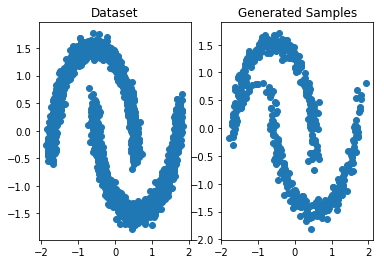

Epoch 226 / 300: Train Loss: 1.222 Test Loss: 1.315
Epoch 227 / 300: Train Loss: 1.242 Test Loss: 1.225
Epoch 228 / 300: Train Loss: 1.221 Test Loss: 1.241
Epoch 229 / 300: Train Loss: 1.205 Test Loss: 1.205
Epoch 230 / 300: Train Loss: 1.194 Test Loss: 1.226
Epoch 231 / 300: Train Loss: 1.215 Test Loss: 1.204
Epoch 232 / 300: Train Loss: 1.184 Test Loss: 1.237
Epoch 233 / 300: Train Loss: 1.191 Test Loss: 1.197
Epoch 234 / 300: Train Loss: 1.178 Test Loss: 1.239
Epoch 235 / 300: Train Loss: 1.190 Test Loss: 1.193
Epoch 236 / 300: Train Loss: 1.211 Test Loss: 1.233
Epoch 237 / 300: Train Loss: 1.266 Test Loss: 1.267
Epoch 238 / 300: Train Loss: 1.230 Test Loss: 1.305
Epoch 239 / 300: Train Loss: 1.273 Test Loss: 1.216
Epoch 240 / 300: Train Loss: 1.236 Test Loss: 1.216
Epoch 241 / 300: Train Loss: 1.207 Test Loss: 1.229
Epoch 242 / 300: Train Loss: 1.237 Test Loss: 1.260
Epoch 243 / 300: Train Loss: 1.208 Test Loss: 1.226
Epoch 244 / 300: Train Loss: 1.194 Test Loss: 1.262
Epoch 245 / 

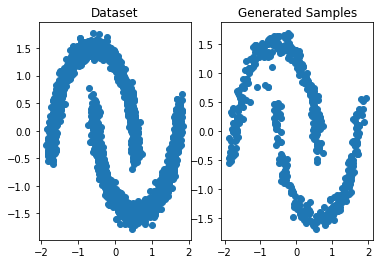

Epoch 251 / 300: Train Loss: 1.209 Test Loss: 1.347
Epoch 252 / 300: Train Loss: 1.280 Test Loss: 1.345
Epoch 253 / 300: Train Loss: 1.315 Test Loss: 1.334
Epoch 254 / 300: Train Loss: 1.332 Test Loss: 1.497
Epoch 255 / 300: Train Loss: 1.305 Test Loss: 1.287
Epoch 256 / 300: Train Loss: 1.269 Test Loss: 1.255
Epoch 257 / 300: Train Loss: 1.246 Test Loss: 1.270
Epoch 258 / 300: Train Loss: 1.224 Test Loss: 1.254
Epoch 259 / 300: Train Loss: 1.217 Test Loss: 1.207
Epoch 260 / 300: Train Loss: 1.193 Test Loss: 1.194
Epoch 261 / 300: Train Loss: 1.181 Test Loss: 1.195
Epoch 262 / 300: Train Loss: 1.186 Test Loss: 1.267
Epoch 263 / 300: Train Loss: 1.190 Test Loss: 1.181
Epoch 264 / 300: Train Loss: 1.188 Test Loss: 1.275
Epoch 265 / 300: Train Loss: 1.258 Test Loss: 1.235
Epoch 266 / 300: Train Loss: 1.198 Test Loss: 1.206
Epoch 267 / 300: Train Loss: 1.178 Test Loss: 1.198
Epoch 268 / 300: Train Loss: 1.195 Test Loss: 1.251
Epoch 269 / 300: Train Loss: 1.217 Test Loss: 1.205
Epoch 270 / 

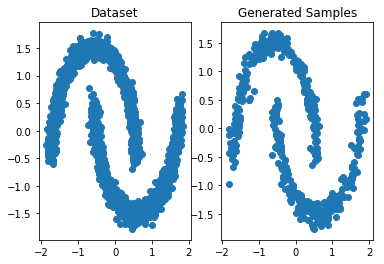

Epoch 276 / 300: Train Loss: 1.197 Test Loss: 1.223
Epoch 277 / 300: Train Loss: 1.202 Test Loss: 1.274
Epoch 278 / 300: Train Loss: 1.205 Test Loss: 1.272
Epoch 279 / 300: Train Loss: 1.217 Test Loss: 1.296
Epoch 280 / 300: Train Loss: 1.273 Test Loss: 1.242
Epoch 281 / 300: Train Loss: 1.251 Test Loss: 1.197
Epoch 282 / 300: Train Loss: 1.207 Test Loss: 1.179
Epoch 283 / 300: Train Loss: 1.215 Test Loss: 1.236
Epoch 284 / 300: Train Loss: 1.213 Test Loss: 1.216
Epoch 285 / 300: Train Loss: 1.241 Test Loss: 1.273
Epoch 286 / 300: Train Loss: 1.272 Test Loss: 1.251
Epoch 287 / 300: Train Loss: 1.276 Test Loss: 1.222
Epoch 288 / 300: Train Loss: 1.222 Test Loss: 1.176
Epoch 289 / 300: Train Loss: 1.193 Test Loss: 1.207
Epoch 290 / 300: Train Loss: 1.199 Test Loss: 1.283
Epoch 291 / 300: Train Loss: 1.223 Test Loss: 1.216
Epoch 292 / 300: Train Loss: 1.207 Test Loss: 1.238
Epoch 293 / 300: Train Loss: 1.212 Test Loss: 1.264
Epoch 294 / 300: Train Loss: 1.197 Test Loss: 1.206
Epoch 295 / 

In [13]:
n_epochs = 300
for epoch in range(n_epochs):
  train_loss, test_loss = train_one_epoch()
  print(f'Epoch {epoch} / {n_epochs}: Train Loss: {train_loss.numpy():.3f} Test Loss: {test_loss.numpy():.3f}')
  if epoch % 25 == 0:
    samples = flow.sample(500)
    plot_progress(samples)

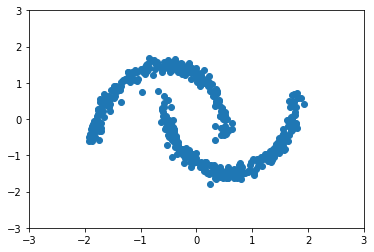

In [19]:
from matplotlib import animation, rc
rc('animation', html='html5')

samples = flow.sample(500)
anim_data = [samples]
for l in flow.layers:
  samples, _ = l(samples, reverse=False)
  anim_data.append(samples)

for l in reversed(flow.layers):
  samples = l(samples, reverse=True)
  anim_data.append(samples)

fig = plt.figure()
scat = plt.scatter(anim_data[0][:, 0], anim_data[0][:, 1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)

def update_plot(i, data, scat):
    scat.set_offsets(data[i])
    return scat,

anim = animation.FuncAnimation(fig, update_plot, interval=500, frames=len(anim_data), fargs=(anim_data, scat))

In [20]:
anim